## 들어가며...
- ResNet 이 나오기 전까지 CNN(convolutional neural network) 모델의 문제는 레이어를 많이 쌓을수록, 모델이 깊을수록 gradient vanishing 문제가 생겼다. 이는 깊어질수록 f(x)를 Loss funtion 으로 미분했을 때 0이 되는 현상이다. ResNet은 이 현상을 degradation 이라고 한다. 이런 안좋은 현상이 생겼을 때, 이를 방지하기 위해 ResNet 논문에선 Residual Block을 고안해 냈고, 이 형태는 H(x) = f(x) + x 형태이다. 이 H(x)는 깊어질수록 f(x)를 Loss funtion 으로 미분했을 때 0이 되는 현상이 일어났을 때 skip connection을 통해 identity mapping 형태로 성능저하가 되지않도록 했다.

![Screenshot from 2021-04-20 23-34-24](https://user-images.githubusercontent.com/60597598/115414409-f9eb2800-a230-11eb-80ab-dc678c3d00d3.png)

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import math
import os

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## cat_dog 데이터셋 다운로드

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

## 데이터셋 확인

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [6]:
ds_info.features["label"].names

['cat', 'dog']

## 255로 정규화 하여 0~1사이의 값 만들기

In [7]:
# 2) Input Normalization
def normalize_and_resize_img(data):
    """Normalizes images: `uint8` -> `float32`."""
    x = data['image']
    y = data['label']
    x = tf.image.resize(x, size=(224,224)) # size 변경 
    x = tf.cast(x, tf.float32) / 255. # size 변경 
    return x, y
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test: # if is_test == Fasle :
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

* 데이터 클래스 2개

In [8]:
ds_info.features["label"].num_classes

2

In [9]:
ds_info.features["label"].names

['cat', 'dog']

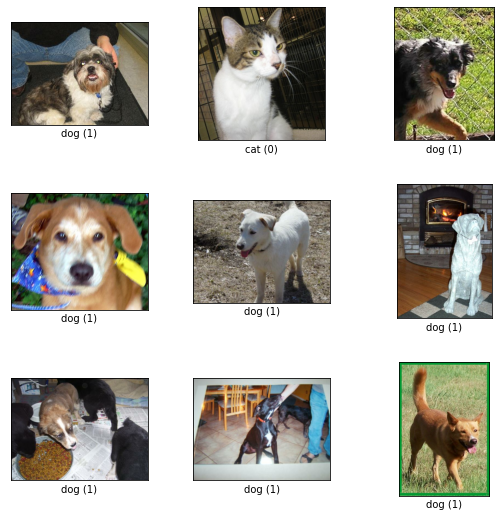

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

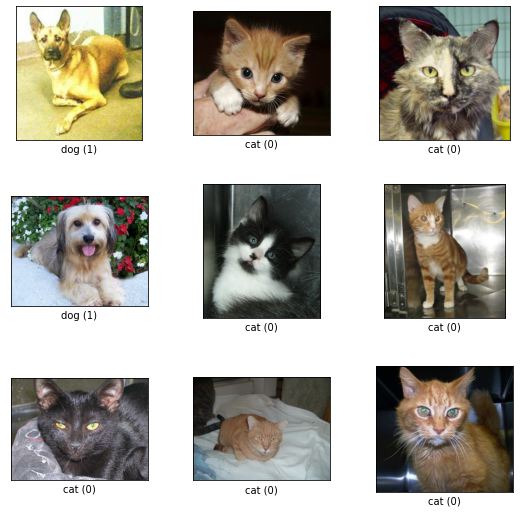

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

# ResNet34, ResNet50, plain34, plain50 모델 만들고 학습 후 비교하기
- ResNet34, ResNet50, plain34, plain50을 설계하고 학습하고 그래프로 비교해보자. plain모델들은 ResNet 모델에서 shortcut 부분과 add부분을 주석처리하면 된다.
- ResNet 논문의 이미지의 구조를 보고 설계하면 된다.
- VGGNet은 max pooling을 사용하였지만 ResNet은 GlobalAveragePooling을 사용하였다. 

![Screenshot from 2021-04-20 23-27-03](https://user-images.githubusercontent.com/60597598/115413781-6e719700-a230-11eb-9965-a5f67ae22ec4.png)

![Screenshot from 2021-04-20 23-31-14](https://user-images.githubusercontent.com/60597598/115413899-89440b80-a230-11eb-89b0-0c984e9f882c.png)

## 모델 만들기, Summary

## ResNet34
- residual block 이 34개 쌓은 ResNet 모델이다.

In [12]:
def Conv1_Layer34(x):    
    x = keras.layers.ZeroPadding2D(padding=(3, 3))(x)
    x = keras.layers.Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.ZeroPadding2D(padding=(1,1))(x)
    return x    
 
def Conv2_Layer34(x):         
    x = keras.layers.MaxPooling2D((3, 3), 2)(x)     
    shortcut = x
    for i in range(3):
            x = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)            
 
            x = keras.layers.Add()([x, shortcut])   
            x = keras.layers.Activation('relu')(x)  
 
            shortcut = x        
    return x
 
def Conv3_Layer34(x):     
    shortcut = x    
    for i in range(4):     
        if(i == 0):            
            x = keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)        
            
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = keras.layers.Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(shortcut) 
            x = keras.layers.BatchNormalization()(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)            
 
            x = keras.layers.Add()([x, shortcut])    
            x = keras.layers.Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
 
            x = keras.layers.Add()([x, shortcut])     
            x = keras.layers.Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
def Conv4_Layer34(x):
    shortcut = x        
    for i in range(6):     
        if(i == 0):                        
            x = keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)  
 
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = keras.layers.Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = keras.layers.BatchNormalization()(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)
 
            x = keras.layers.Add()([x, shortcut]) 
            x = keras.layers.Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
 
            x = keras.layers.Add()([x, shortcut])    
            x = keras.layers.Activation('relu')(x)
 
            shortcut = x      
    return x
 
def Conv5_Layer34(x):

    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)        

            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = keras.layers.Conv2D(512, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = keras.layers.BatchNormalization()(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)            
 
            x = keras.layers.Add()([x, shortcut])  
            x = keras.layers.Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)           
            
            x = keras.layers.Add()([x, shortcut]) 
            x = keras.layers.Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 


In [13]:
res_input_layer = keras.layers.Input(shape=(224,224,3))

In [14]:
K=2

x = Conv1_Layer34(res_input_layer)
x = Conv2_Layer34(x)
x = Conv3_Layer34(x)
x = Conv4_Layer34(x)
x = Conv5_Layer34(x)
 
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten(name='flatten')(x)
res_block_output = keras.layers.Dense(K, activation='softmax',name='fc1000')(x)

In [15]:
# 블록 1개짜리 model 생성
model_res34 = keras.Model(inputs=res_input_layer, outputs=res_block_output)  

model_res34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

# ResNet_50

In [16]:
def Conv1_Layer50(x):    
    x = keras.layers.ZeroPadding2D(padding=(3, 3))(x)
    x = keras.layers.Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
def Conv2_Layer50(x):         
    x = keras.layers.MaxPooling2D((3, 3), 2)(x)     
    shortcut = x
    for i in range(3):
        if (i == 0):
            x = keras.layers.Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = keras.layers.Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = keras.layers.BatchNormalization()(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)
 
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = keras.layers.Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)            
 
            x = keras.layers.Add()([x, shortcut])   
            x = keras.layers.Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
def Conv3_Layer50(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = keras.layers.Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)        
            
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)  
 
            x = keras.layers.Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = keras.layers.Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = keras.layers.BatchNormalization()(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)            
 
            x = keras.layers.Add()([x, shortcut])    
            x = keras.layers.Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = keras.layers.Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)            
 
            x = keras.layers.Add()([x, shortcut])     
            x = keras.layers.Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
def Conv4_Layer50(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = keras.layers.Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)        
            
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)  
 
            x = keras.layers.Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = keras.layers.Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = keras.layers.BatchNormalization()(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)
 
            x = keras.layers.Add()([x, shortcut]) 
            x = keras.layers.Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = keras.layers.Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)            
 
            x = keras.layers.Add()([x, shortcut])    
            x = keras.layers.Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
def Conv5_Layer50(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = keras.layers.Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)        
            
            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)  
 
            x = keras.layers.Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = keras.layers.Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = keras.layers.BatchNormalization()(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)            
 
            x = keras.layers.Add()([x, shortcut])  
            x = keras.layers.Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = keras.layers.Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)           
            
            x = keras.layers.Add()([x, shortcut]) 
            x = keras.layers.Activation('relu')(x)       
 
            shortcut = x                  
 
    return x

In [17]:
res_input_layer = keras.layers.Input(shape=(224,224,3))

In [18]:
x = Conv1_Layer50(res_input_layer)
x = Conv2_Layer50(x)
x = Conv3_Layer50(x)
x = Conv4_Layer50(x)
x = Conv5_Layer50(x)
 
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten(name='flatten')(x)
res_block_output = keras.layers.Dense(K, activation='softmax', name='fc1000')(x)

In [19]:
model_res50 = keras.Model(inputs=res_input_layer, outputs=res_block_output)  

model_res50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 112, 112, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 112, 112, 64) 256         conv2d_36[0][0]                  
____________________________________________________________________________________________

# Plain_34 만들기

In [20]:
def Plain1_Layer34(x):    
    x = keras.layers.ZeroPadding2D(padding=(3, 3))(x)
    x = keras.layers.Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.ZeroPadding2D(padding=(1,1))(x)
    return x    
 
def Plain2_Layer34(x):         
    x = keras.layers.MaxPooling2D((3, 3), 2)(x)     

    for i in range(3):
            x = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)            
            x = keras.layers.Activation('relu')(x)  
      
    return x
 
def Plain3_Layer34(x):     
    
    for i in range(4):     
        if(i == 0):            
            x = keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)        
            
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
 
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)             
        
        else:
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)   
            x = keras.layers.Activation('relu')(x)
            
    return x
 
def Plain4_Layer34(x):
         
    for i in range(6):     
        if(i == 0):                        
            x = keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)  
 
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x) 
            x = keras.layers.Activation('relu')(x)             
        
        else:
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
  
    return x
 
def Plain5_Layer34(x):

    for i in range(3):     
        if(i == 0):            
            x = keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)        

            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)     
            x = keras.layers.Activation('relu')(x)                   
        
        else:
            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)           
            x = keras.layers.Activation('relu')(x)       
          
 
    return x

In [21]:
plain_input_layer = keras.layers.Input(shape=(224,224,3))

In [22]:
x = Plain1_Layer34(plain_input_layer)
x = Plain2_Layer34(x)
x = Plain3_Layer34(x)
x = Plain4_Layer34(x)
x = Plain5_Layer34(x)
 
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten(name='flatten')(x)
plain_block_output = keras.layers.Dense(K, activation='softmax',name='fc1000')(x)
# 블록 1개짜리 model 생성
model_plain34 = keras.Model(inputs=plain_input_layer, outputs=plain_block_output)  

model_plain34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 230, 230, 3)       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0   

In [23]:
def Plain1_Layer50(x):    
    x = keras.layers.ZeroPadding2D(padding=(3, 3))(x)
    x = keras.layers.Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
def Plain2_Layer50(x):         
    x = keras.layers.MaxPooling2D((3, 3), 2)(x)     

    for i in range(3):
        if (i == 0):
            x = keras.layers.Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)           
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
        else:
            x = keras.layers.Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)            
            x = keras.layers.Activation('relu')(x)    
    
    return x
 
def Plain3_Layer50(x):        
    
    for i in range(4):     
        if(i == 0):            
            x = keras.layers.Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)        
            
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)  
 
            x = keras.layers.Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)       
            x = keras.layers.Activation('relu')(x)              
        
        else:
            x = keras.layers.Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)                
            x = keras.layers.Activation('relu')(x)
            
    return x
 
def Plain4_Layer50(x):      
  
    for i in range(6):     
        if(i == 0):            
            x = keras.layers.Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)        
            
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)  
 
            x = keras.layers.Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)            
        
        else:
            x = keras.layers.Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)              
            x = keras.layers.Activation('relu')(x)
 
    return x
 
def Plain5_Layer50(x): 
  
    for i in range(3):     
        if(i == 0):            
            x = keras.layers.Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)        
            
            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)  
 
            x = keras.layers.Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)      

        else:
            x = keras.layers.Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            
            x = keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
 
            x = keras.layers.Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = keras.layers.BatchNormalization()(x)           
            x = keras.layers.Activation('relu')(x)       
                 
 
    return x

In [24]:
plain_input_layer = keras.layers.Input(shape=(224,224,3))

In [25]:
x = Plain1_Layer50(plain_input_layer)
x = Plain2_Layer50(x)
x = Plain3_Layer50(x)
x = Plain4_Layer50(x)
x = Plain5_Layer50(x)
 
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten(name='flatten')(x)
plain_block_output = keras.layers.Dense(K, activation='softmax',name='fc1000')(x)
# 블록 1개짜리 model 생성
model_plain50 = keras.Model(inputs=plain_input_layer, outputs=plain_block_output)  

model_plain50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 230, 230, 3)       0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0   

# 모델 학습하기
- batch_size를 256으로 돌렸을때 RTX2070기준 gpu_memory에러가 났다. 그래서 16으로 낮추어 실행했다.

In [26]:
BATCH_SIZE = 16
EPOCH = 50

In [27]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)

In [28]:
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [29]:
model_res34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = model_res34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
1163/1163 [==============================] - 117s 87ms/step - loss: 0.6791 - accuracy: 0.5979 - val_loss: 0.6927 - val_accuracy: 0.6128
Epoch 2/50
1163/1163 [==============================] - 107s 92ms/step - loss: 0.6059 - accuracy: 0.6716 - val_loss: 0.8031 - val_accuracy: 0.6084
Epoch 3/50
1163/1163 [==============================] - 96s 83ms/step - loss: 0.5471 - accuracy: 0.7225 - val_loss: 0.7802 - val_accuracy: 0.5865
Epoch 4/50
1163/1163 [==============================] - 97s 83ms/step - loss: 0.4715 - accuracy: 0.7763 - val_loss: 0.5030 - val_accuracy: 0.7666
Epoch 5/50
1163/1163 [==============================] - 99s 85ms/step - loss: 0.4036 - accuracy: 0.8181 - val_loss: 0.4424 - val_accuracy: 0.8151
Epoch 6/50
1163/1163 [==============================] - 93s 80ms/step - loss: 0.3254 - accuracy: 0.8597 - val_loss: 0.5562 - val_accuracy: 0.7765
Epoch 7/50
1163/1163 [==============================] - 93s 80ms/step - loss: 0.2520 - accuracy: 0.8949 - val_loss: 0.6061

In [30]:
model_res50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = model_res50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
1163/1163 [==============================] - 218s 162ms/step - loss: 0.7206 - accuracy: 0.5551 - val_loss: 1.1139 - val_accuracy: 0.5283
Epoch 2/50
1163/1163 [==============================] - 157s 135ms/step - loss: 0.6832 - accuracy: 0.6055 - val_loss: 0.9275 - val_accuracy: 0.5289
Epoch 3/50
1163/1163 [==============================] - 157s 135ms/step - loss: 0.6800 - accuracy: 0.6147 - val_loss: 1.0069 - val_accuracy: 0.5278
Epoch 4/50
1163/1163 [==============================] - 157s 135ms/step - loss: 0.6695 - accuracy: 0.6265 - val_loss: 0.7621 - val_accuracy: 0.6009
Epoch 5/50
1163/1163 [==============================] - 157s 135ms/step - loss: 0.6617 - accuracy: 0.6278 - val_loss: 0.6783 - val_accuracy: 0.6280
Epoch 6/50
1163/1163 [==============================] - 157s 135ms/step - loss: 0.6440 - accuracy: 0.6419 - val_loss: 0.7594 - val_accuracy: 0.6232
Epoch 7/50
1163/1163 [==============================] - 157s 135ms/step - loss: 0.6222 - accuracy: 0.6637 - val_

In [31]:
model_plain34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = model_plain34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
1163/1163 [==============================] - 95s 77ms/step - loss: 0.7050 - accuracy: 0.5205 - val_loss: 1.2341 - val_accuracy: 0.4849
Epoch 2/50
1163/1163 [==============================] - 89s 77ms/step - loss: 0.6880 - accuracy: 0.5532 - val_loss: 1.1809 - val_accuracy: 0.5259
Epoch 3/50
1163/1163 [==============================] - 89s 77ms/step - loss: 0.6743 - accuracy: 0.5889 - val_loss: 0.9171 - val_accuracy: 0.5205
Epoch 4/50
1163/1163 [==============================] - 89s 77ms/step - loss: 0.6633 - accuracy: 0.6004 - val_loss: 0.7104 - val_accuracy: 0.5932
Epoch 5/50
1163/1163 [==============================] - 89s 77ms/step - loss: 0.6570 - accuracy: 0.6109 - val_loss: 0.9701 - val_accuracy: 0.5531
Epoch 6/50
1163/1163 [==============================] - 89s 77ms/step - loss: 0.6492 - accuracy: 0.6175 - val_loss: 0.6820 - val_accuracy: 0.5925
Epoch 7/50
1163/1163 [==============================] - 89s 77ms/step - loss: 0.6334 - accuracy: 0.6350 - val_loss: 0.6200 -

In [32]:
model_plain50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = model_plain50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
1163/1163 [==============================] - 139s 113ms/step - loss: 0.7080 - accuracy: 0.5285 - val_loss: 0.7128 - val_accuracy: 0.5095
Epoch 2/50
1163/1163 [==============================] - 131s 113ms/step - loss: 0.7103 - accuracy: 0.5255 - val_loss: 0.7104 - val_accuracy: 0.5190
Epoch 3/50
1163/1163 [==============================] - 131s 113ms/step - loss: 0.7085 - accuracy: 0.5312 - val_loss: 0.9890 - val_accuracy: 0.4938
Epoch 4/50
1163/1163 [==============================] - 131s 113ms/step - loss: 0.7064 - accuracy: 0.5294 - val_loss: 0.7659 - val_accuracy: 0.5429
Epoch 5/50
1163/1163 [==============================] - 131s 113ms/step - loss: 0.7008 - accuracy: 0.5413 - val_loss: 0.7618 - val_accuracy: 0.5052
Epoch 6/50
1163/1163 [==============================] - 131s 113ms/step - loss: 0.7057 - accuracy: 0.5185 - val_loss: 0.9362 - val_accuracy: 0.5157
Epoch 7/50
1163/1163 [==============================] - 131s 113ms/step - loss: 0.7081 - accuracy: 0.5011 - val_

# ResNet34, ResNet50, plain34, plain50 그래프로 출력하기
- loss와 accuracy를 그래프로 출력하였다.

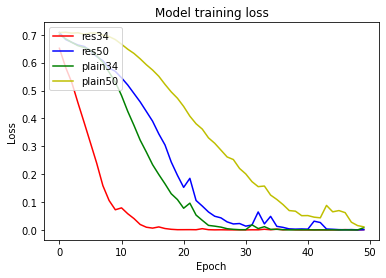

In [36]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'g')
plt.plot(history_plain_50.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['res34', 'res50', 'plain34', 'plain50'], loc='upper left')
plt.show()

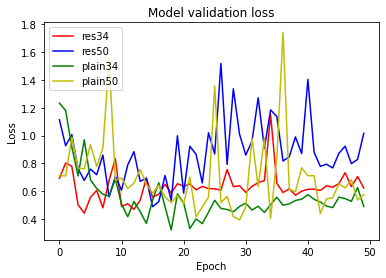

In [38]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'g')
plt.plot(history_plain_50.history['val_loss'], 'y')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['res34', 'res50', 'plain34', 'plain50'], loc='upper left')
plt.show()

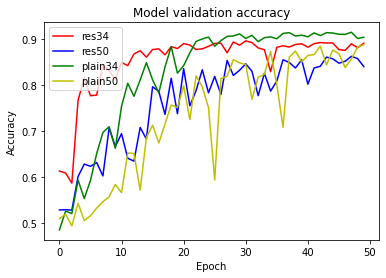

In [34]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'g')
plt.plot(history_plain_50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['res34', 'res50', 'plain34', 'plain50'], loc='upper left')
plt.show()

# 결과분석1
- (224, 224, 3) 이미지 사이즈로 batch size = 16, epoch =50 만큼 학습시켰다.
- res34 > plain34 > res50 > plain50 순으로 결과가 좋게 나온 것 같다.
- res34가 가장 결과가 좋게 나온것 같다.
- validation loss 그래프에서는 res50이 유독 높게 나왔다.  

## 기존 ResNet 논문에서의 결과
![Screenshot from 2021-04-21 07-25-39](https://user-images.githubusercontent.com/60597598/115471400-e06ad000-a272-11eb-9f6c-ada7cdc14206.png)
![Screenshot from 2021-04-21 07-27-51](https://user-images.githubusercontent.com/60597598/115471553-1f008a80-a273-11eb-9fa1-7789d74da469.png)

# 결과 분석2
- 그래프를 확인했을 때, ResNet의 의도대로 나오지 않은것 같다. ResNet의 의도대로라면 res50이 더 깊은 모델이니 res34보다 loss와 accuracy가 좋게 나와야 할 것 같은데 안좋게 나왔다. 
- plain50은 accuracy가 확 떨어지는 구간이 있었다. 이는 좋지 않은 현상이며, res50은 이런 현상이 없다.
- 기존 논문에서는 batch size를 256으로 두고 했는데, 이 프로젝트에선 16으로 하였다. 이 낮은 batch size 때문에 resNet의 의도대로 나오지 않았을수도 있을 것 같다. 좀 더 좋은 gpu 환경해서 구현하면 다른 결과가 나올수도 있을 것 같다.
- 입력 이미지 또한 사이즈가 큰 것 같다. 입력 이미지 사이즈가 좀 더 작은 (32, 32, 3)이면 좀 더 ResNet의 의도된 결과가 나올수도 있을 것 같다.
- 이런 loss, accuracy 그래프보단, 실제 이미지를 넣었을 때 개인지 고양이인지 구분한 error로 비교를 해봐야 될 것 같다.

#### 루브릭
1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?
- 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.

2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?
- cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.

3. Ablation Study 결과가 바른 포맷으로 제출되었는가?
- ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.